<a href="https://colab.research.google.com/github/avner8943/bootcamp/blob/master/Transfer_learnning_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision


In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np


class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        

        self.conv1 = nn.Conv2d(3, 6, 5)

        self.conv2 = nn.Conv2d(6, 16, 5)

        # randomly select number of feagtures
        fet1 = np.random.randint(100, 400)

        fet2 = np.random.randint(100, 400)

        
        self.fc1 = nn.Linear(in_features= 16 * 5 * 5, out_features=fet1)  # 6*6 from image dimension
        
        self.fc2 = nn.Linear(in_features=fet1, out_features=fet2)

        self.fc3 = nn.Linear(in_features=fet2, out_features=n_classes)
    
    def forward(self, x):

        x = F.max_pool2d(torch.relu(self.conv1(x)), kernel_size=2)
        x = F.max_pool2d(torch.relu(self.conv2(x)), kernel_size=2)
  
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)

        return x

In [65]:
class im_resize(object):

  def __init__(self, o_shape = (3,32,32)):
    self.o_shape = o_shape



  def __call__(self, im):

    c, h, w = self.o_shape
    new_im = transforms.Resize(im, (c,h, w))

    return new_im

In [79]:
def data_loader_CIFAR10():

  transform = transforms.Compose(
      [transforms.ToTensor(),
       transforms.RandomHorizontalFlip(p=0.5),
       transforms.Resize((32,32)),
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform)
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=4,
                                            shuffle=True, num_workers=2)

  test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=4,
                                          shuffle=False, num_workers=2)
  classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
  return train_set, train_loader, test_set, test_loader, classes

In [80]:
import torch.optim as optim

train_set, train_loader, test_set, test_loader, classes = data_loader_CIFAR10()
print(train_loader)

net = LeNet5(len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Files already downloaded and verified
Files already downloaded and verified


In [81]:
# train model
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #print(outputs.shape, inputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

[1,  2000] loss: 2.131
[1,  4000] loss: 1.787
[1,  6000] loss: 1.651
[1,  8000] loss: 1.576
[1, 10000] loss: 1.486
[1, 12000] loss: 1.439
[2,  2000] loss: 1.389
[2,  4000] loss: 1.337
[2,  6000] loss: 1.332
[2,  8000] loss: 1.278
[2, 10000] loss: 1.248
[2, 12000] loss: 1.254


In [83]:
# evaluate model
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


same results as for last assignment

### Q2.a implent tutorial transfer learnning from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [72]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

In [73]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [74]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['.ipynb_checkpoints', 'ants', 'bees']


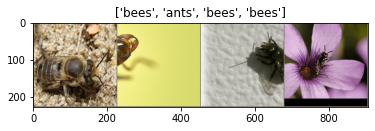

In [75]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [83]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                #inputs = inputs.to(device)
                #labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    print(preds, labels)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [77]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            #inputs = inputs.to(device)
            #labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [84]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))


#model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [85]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
tensor([0, 2, 2, 2]) tensor([1, 2, 2, 1])
tensor([2, 0, 1, 2]) tensor([2, 1, 1, 1])
tensor([2, 2, 1, 1]) tensor([2, 1, 1, 1])
tensor([1, 2, 1, 2]) tensor([1, 2, 1, 2])


KeyboardInterrupt: ignored

In [ ]:
visualize_model(model_ft)